In [102]:
"""
    Authors: 
        Ali Karimiafshar <karimiafsharali@gmail.com>
        Vitor Freitas <vit1905@live.missouristate.edu>
        Kadidia Kantao
    Date:
        12/09/2021
    Dataset:
        https://www.kaggle.com/c/digit-recognizer/data
""";

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict

In [104]:
# Read the data and display the first seven elements.
data = pd.read_csv("train.csv")
data.head(7)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
# Convert data to numpy array
data = np.array(data)

# Divide the data in two groups for training (80%) and testing (20%).
dataSampleSize, features = data.shape
splitPoint = int(dataSampleSize*0.80)

# Transpose the data so that each column corresponds with a new sample and each rwo with the pixel values.
# Normalize the pixel values to a range [0, 1].
data_train = data[:splitPoint].T
X_train = data_train[1:] / 255
Y_train = data_train[0]

data_cross = data[splitPoint:].T
X_cross = data_cross[1:] / 255
Y_cross = data_cross[0]

In [106]:
class NeuralNetworkLayer:
    def __init__(self, cur_num_neurons:int, next_num_neurons:int=10) -> None:
        """ A Neural Network Layer that creates weights and biases arrays for the Neural Network \
            according to the number of neurons in the current layer and the next layer.

        Args:
            cur_num_neurons (int): Number of neurons on the current layer. Weights matrix columns.
            next_num_neurons (int, optional): Number of neurons on the next layer. Weights matrix rows. Defaults to 10.
        """
        
        # Initial range of randoms weights and biases is [-0.50, 0.50].
        randRange = 0.5
        np.random.seed(171317)
        self.weights = np.random.uniform(-randRange, randRange, size=(next_num_neurons, cur_num_neurons))
        self.biases = np.random.uniform(-randRange, randRange, size=(next_num_neurons, 1))
        self.output = None
        self.output_activated = None
        
        
    def forward_prop(self, inputData:np.array) -> np.array:
        """ Forward propagation. Performs matrix multiplication between weights and input data, then adds biases.

        Args:
            inputData (np.array): Input data or output data from the last neuron layer.

        Returns:
            np.array: The matrix multiplication product of weights and inputData plus the bias
        """
        
        self.output = self.weights.dot(inputData) + self.biases
        return self.output
        
        
    def activation_ReLU(self) -> np.array:
        """ ReLU activation function.

        Returns:
            np.array: The forward propagation output, or zero, whichever is greater.
        """
        
        # Element-wise maximum comparison.
        self.output_activated = np.maximum(0, self.output)
        return self.output_activated
    
    
    def derivative_activation_ReLU(self) -> np.array:
        """ ReLU derivative used for backward propagation. 

        Returns:
            np.array: The derivative of the ReLU activation function, which is 1 when f>0, or 0 otherwise.
        """
        
        # Bool will be converted to 0 or 1 when type casting.
        return self.output_activated > 0
    
    
    def activation_softmax(self) -> np.array:
        """ Softmax activation function.

        Returns:
            np.array: The matrix prediction of the model based on the input data, weights, and biases of the Neural Network Layers. 
        """
        
        # Element-wise exponential function divided by the sum of all exponential functions e^x.
        self.output_activated = np.exp(self.output) / sum(np.exp(self.output))
        return self.output_activated
    
    
    def update_weights_biases(self, dW:np.array, dB:float, alpha:float) -> None:
        """ Updates the weights and biases of the neural network layer based on the back propagation calculations.

        Args:
            dW (np.array): Change in weights.
            dB (float): Change in biases.
            alpha (float): Learning rate.
        """
        
        self.weights -= alpha * dW
        self.biases -= alpha * dB

In [107]:
class DigitRecognizerNeuralNetwork:
    def __init__(self, X:np.array, Y:np.array, SampleSize:int, iterations:int=500, alpha:float=0.10, isTraining=True, learned_wnb:Dict=None) -> None:
        """ The Neural Network designed to classify handwriting digit samples found in the Kaggle dataset. 

        Args:
            X (np.array): The training or testing data. Excludes the label.
            Y (np.array): The data label.
            SampleSize (int): Size of the dataset.
            iterations (int, optional): Number of times the neural network is trained on the training dataset. Defaults to 500.
            alpha (float, optional): Learning rate. Defaults to 0.10.
            isTraining (bool, optional): If True, the network is a training network, otherwise a testing network.
            learned_wnb (Dict, optional): The dictionary of learned weights and biases.
        """
        
        # Create the neuron layers
        self.hiddenLayer = NeuralNetworkLayer(784,10)
        self.outputLayer = NeuralNetworkLayer(10,10)
        
        # Initialize variables
        self.X = X
        self.Y = Y
        self.size = SampleSize
        self.iterations = iterations
        self.alpha = alpha
        
        # train the model if it is a training network, otherwise test cross validation data.
        if isTraining:
            self.gradient_descent()
        else:
            self.test_cross_data(learned_wnb)
            

    def forward_prop(self) -> None:
        """ Calls the appropriate forward propagation and activation functions for each layer.
        """
        
        hiddenLayer_output = self.hiddenLayer.forward_prop(self.X)
        hiddenLayer_activated = self.hiddenLayer.activation_ReLU()
        
        # Outputs of the hidden layer are the inputs to the output layer.
        outputLayer_output = self.outputLayer.forward_prop(hiddenLayer_activated)
        outputLayer_activated = self.outputLayer.activation_softmax()
                

    def get_actual_label(self, Y:np.array) -> np.array:
        """ Generates an array of zeros with a 1 in the index of the actual label of the training data. \
            This is used to calculate the deviation of the network prediction from the actual label.

        Args:
            Y (np.array): The label array of training data

        Returns:
            np.array: array of zeros with only one value of 1 at the index of the label Y.
        """
        
        # Generate array of zeros
        actual_y = np.zeros((Y.size, 10))
        
        # for each row (data), replace the column Y index (label index), with a 1.
        actual_y[[i for i in range(Y.size)], Y] = 1
        
        # Transpose and return the array so that each row corresponds with the value of the label.
        # For example, if the label of the first row is 4, return [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] as the columns of the first row.
        # Then transpose and return.
        return actual_y.T
    
    
    def backward_prop(self) -> None:
        """ Performs the back propagation algorithm to calculate how much weights and biases of each layer need to be changed by.
        """
        
        # Array of zeroes with one 1 at the index of the actual label of the data.
        actual_y = self.get_actual_label(self.Y)
        
        # Determine how the output layer weights and biases need to be updated.
        dZ_outputLayer = self.outputLayer.output_activated - actual_y
        dW_outputLayer = 1 / self.size * dZ_outputLayer.dot(self.hiddenLayer.output_activated.T)
        db_outputLayer = 1 / self.size * np.sum(dZ_outputLayer)
        
        # Determine how the hidden layer weights and biases need to be updated.
        dZ_hiddenLayer = self.outputLayer.weights.T.dot(dZ_outputLayer) * self.hiddenLayer.derivative_activation_ReLU()
        dW_hiddenLayer = 1 / self.size * dZ_hiddenLayer.dot(self.X.T)
        db_hiddenLayer = 1 / self.size * np.sum(dZ_hiddenLayer)
        
        # Updates the weights and biases of each layer.
        self.outputLayer.update_weights_biases(dW_outputLayer, db_outputLayer, self.alpha)
        self.hiddenLayer.update_weights_biases(dW_hiddenLayer, db_hiddenLayer, self.alpha)
        
        
    def get_predictions(self, outputLayer_output:np.array) -> np.array:
        """ calculates the prediction of the neural network based on the maximum of the output layer.

        Args:
            outputLayer_output (np.array): values of the output layer, whose maximum would be the network prediction.

        Returns:
            np.array: index of the maximum value of the output layer, which corresponds with the digit predicted in range [0, 9]. 
        """
        
        return np.argmax(outputLayer_output, 0)


    def get_accuracy(self, predictions:np.array, Y:np.array, numDigitsToShow:int=17) -> float:
        """ Calculates the accuracy of the model.

        Args:
            predictions (np.array): array of the network predictions based on the activation function of the output layer.
            Y (np.array): array of the actual data labels.
            numDigitsToShow (int, optional): Number of first elements of prediction and label arrays to discplay. Defaults to 17.

        Returns:
            float: Accuracy of the model out of 100%.
        """
        
        accuracy = np.sum(predictions == Y) / Y.size
        
        if numDigitsToShow:
            print(f"Network predictions:\t{predictions[:numDigitsToShow]}\nActual labels:\t\t{Y[:numDigitsToShow]}")
        
        return accuracy
    
    
    def gradient_descent(self) -> None:
        """ Performs the gradient decent a number of iterations to train the model. \
            Calls forward_prop, and backward_prop, then displays updated accuracy of the model with every 10 iterations.
        """
        
        for i in range(1, self.iterations+1):
            self.forward_prop()
            self.backward_prop()
            
            # For every 10 training iterations, display updates.
            if (i % 10) == 0:
                print(f"iteration: {i}")
                self.display_updates()
        
        # After the training iterations, store the weights and biases in tunes dictionary.
        self.tunes = {"hiddenLayer_weights":self.hiddenLayer.weights,
                      "hiddenLayer_biases":self.hiddenLayer.biases,
                      "outputLayer_weights":self.outputLayer.weights,
                      "outputLayer_biases":self.outputLayer.biases}
        
    
    def display_updates(self) -> None:
        """ Displays updated accuracy of the model.
        """
        
        neural_network_output = self.outputLayer.output
        self.predictions = self.get_predictions(neural_network_output)
        accuracy = self.get_accuracy(self.predictions, self.Y)
        print(f"Accuracy:\t{accuracy*100:.2f}%")
    
    
    def load_weights_and_biases(self, wnb_dict:Dict) -> None:
        """ Loads learned weights and biases into the model for testing unexamined sample data.

        Args:
            wnb_dict (Dict): Dictionary of the weights and biases.
        """
        
        self.hiddenLayer.weights = wnb_dict["hiddenLayer_weights"]
        self.hiddenLayer.biases = wnb_dict["hiddenLayer_biases"]
        self.outputLayer.weights = wnb_dict["outputLayer_weights"]
        self.outputLayer.biases = wnb_dict["outputLayer_biases"]
    
    
    def test_cross_data(self, learned_wnb:Dict) -> None:
        """ Classifies cross validation data based on the learned weights and biases. \
            Then displays the accuracy of the model.

        Args:
            learned_wnb (Dict): learned weights and biases to be loaded into the network.
        """
        
        self.load_weights_and_biases(learned_wnb)
        self.forward_prop()
        self.display_updates()

In [108]:
digit_neural_network = DigitRecognizerNeuralNetwork(X_train, Y_train, dataSampleSize, iterations=500, alpha=0.10)
learned_weights_and_biases = digit_neural_network.tunes

iteration: 10
Network predictions:	[1 8 4 2 2 2 6 1 2 2 8 8 1 5 2 5 1]
Actual labels:		[1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2]
Accuracy:	15.70%
iteration: 20
Network predictions:	[1 2 1 2 2 2 6 9 0 2 8 8 1 5 2 5 1]
Actual labels:		[1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2]
Accuracy:	23.13%
iteration: 30
Network predictions:	[1 2 1 2 2 2 6 9 0 2 9 9 1 5 2 5 1]
Actual labels:		[1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2]
Accuracy:	27.77%
iteration: 40
Network predictions:	[1 2 1 2 2 2 6 8 0 2 8 9 1 5 2 5 1]
Actual labels:		[1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2]
Accuracy:	31.56%
iteration: 50
Network predictions:	[1 0 1 2 2 2 6 4 0 0 8 9 1 1 2 1 1]
Actual labels:		[1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2]
Accuracy:	34.91%
iteration: 60
Network predictions:	[1 0 1 2 2 2 6 4 0 2 8 9 1 1 2 1 1]
Actual labels:		[1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2]
Accuracy:	38.29%
iteration: 70
Network predictions:	[1 0 1 4 0 2 7 4 0 2 8 9 1 1 2 1 1]
Actual labels:		[1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2]
Accuracy:	41.51%
iteration: 80
Networ

In [109]:
testing_digit_network = DigitRecognizerNeuralNetwork(X_cross, Y_cross, dataSampleSize, 0, 0, isTraining=False, learned_wnb=learned_weights_and_biases)

Network predictions:	[0 7 7 2 2 6 0 7 3 5 2 0 7 7 6 9 2]
Actual labels:		[0 7 7 2 2 6 5 7 8 5 3 0 2 7 6 9 2]
Accuracy:	83.77%


Actual label:	8
pred label:	3



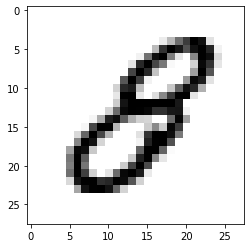

In [110]:
ix = 8
Y_cross[ix]
pred = testing_digit_network.predictions

def display_sample(X, ix, predictions):
    pixels = X[:,ix].reshape(28, 28)
    print(f"Actual label:\t{Y_cross[ix]}\npred label:\t{predictions[ix]}\n")
    plt.imshow(pixels, plt.cm.gray_r)


display_sample(X_cross, ix, pred)

In [111]:
# for n in range(0, 7):
#     # n = 1
#     # print(X_train[:,n].shape)
#     digit = X_train[:,n].reshape(28, 28)
#     plt.figure()
#     plt.imshow(digit, plt.cm.gray_r)
#     # out = a.NNoutput[:,0]
#     Y_train[n]
#     # pred = a.get_predictions(a.NNoutput)
#     pred = testing_digit_network.predictions
#     print(f"Label: {Y_train[n]}\tPrediction:{pred[n]}\n")

In [112]:
display_sample(9, X_train, Y_train, out)

NameError: name 'out' is not defined